### IMPORT LIBRARIES

# Import libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

#import tensorflow_addons as tfa
#from tensorflow.keras.metrics import Metric
#from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typeguard import typechecked
from typing import Optional
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import keras.backend as K

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocessing On the data

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [59]:


train_dataset  = train_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [5]:

valid_dataset = valid_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [6]:

test_dataset = test_datagen.flow_from_directory(directory = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 1)

Found 1279 images belonging to 4 classes.


## feature preprocessing and label encoding.

### MODEL BUILDING

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

2023-01-08 14:14:51.023780: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:14:51.123367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:14:51.124118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-08 14:14:51.125416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

9420800/9406464 [==============================] - 0s 0us/step


In [8]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [9]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [10]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 62720)             250880    
_________________________________________________________________
dense (Dense)                (None, 32)                2007072   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

# draw model

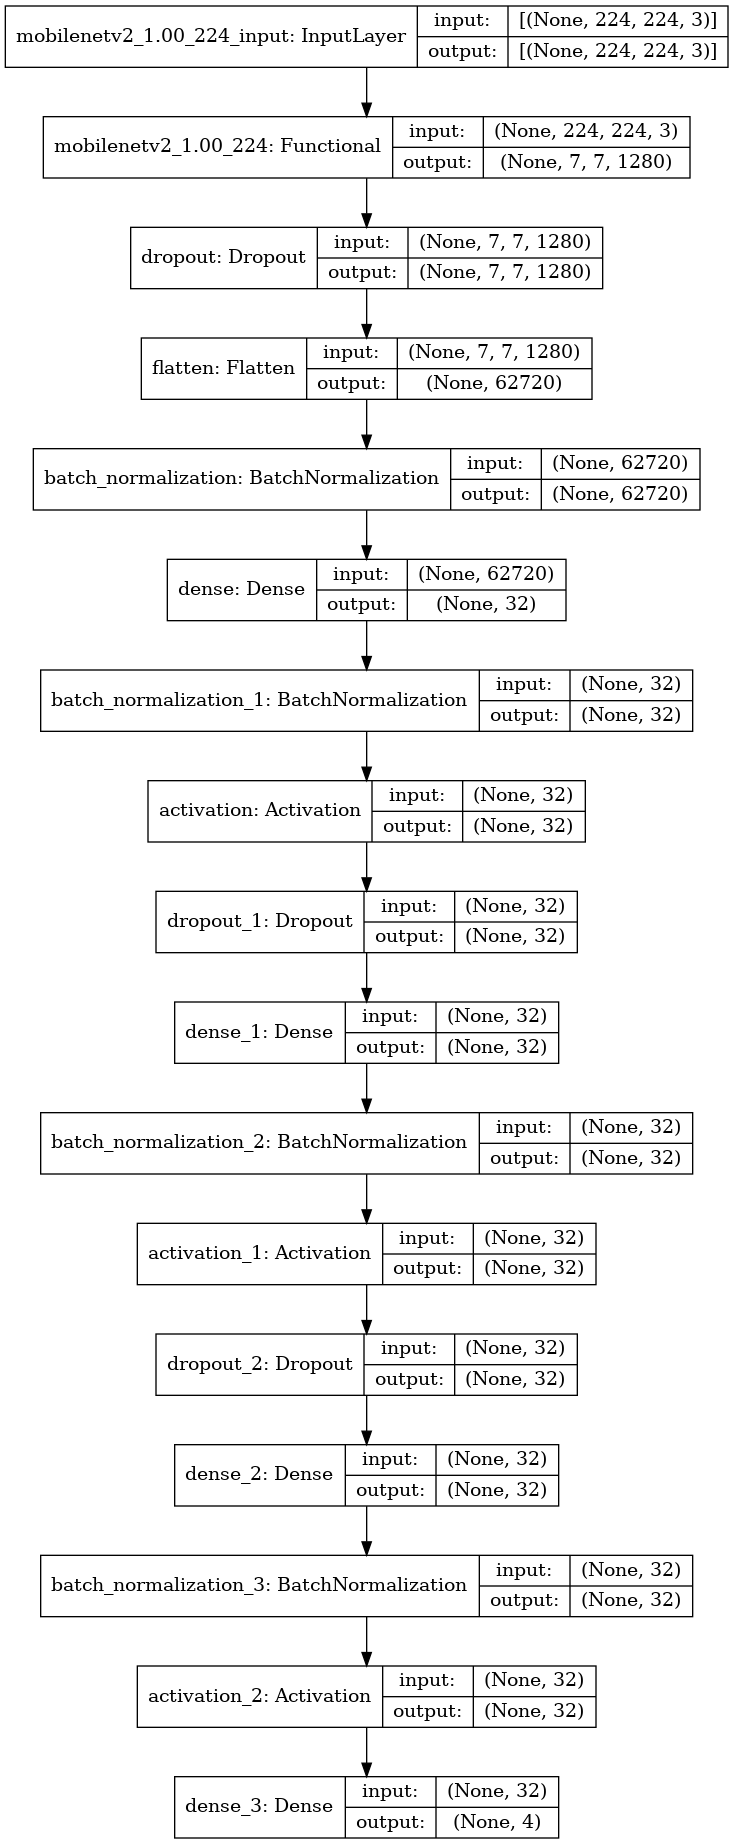

In [61]:
from tensorflow.keras.utils import to_categorical, plot_model
plot_model(model, to_file='model-mnist.png', show_shapes=True)

In [11]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [13]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [14]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [16]:
from tensorflow.keras.utils import to_categorical, plot_model
#plot_model(model, to_file='NN-mnist.png', show_shapes=True)

In [17]:
#model.load_weights("/kaggle/input/zahaimar-22/zahaimar_v2.h5")

In [52]:
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_dataset),
                                        y = train_dataset                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

In [20]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}               

In [21]:

history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 50,
                        verbose = 1,
                        class_weight=class_weights,
                        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
                 )

2023-01-08 14:14:56.016836: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-08 14:15:01.571154: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


129/129 [==============================] - 78s 527ms/step - loss: 3.1072 - accuracy: 0.7331 - precision: 0.2557 - recall: 0.0354 - auc: 0.5537 - f1_score: 0.0565 - val_loss: 1.3679 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5601 - val_f1_score: 0.0000e+00


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
129/129 [==============================] - 50s 391ms/step - loss: 2.7992 - accuracy: 0.7442 - precision: 0.2613 - recall: 0.0127 - auc: 0.5099 - f1_score: 0.0235 - val_loss: 1.3407 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6971 - val_f1_score: 0.0000e+00
Epoch 3/50
129/129 [==============================] - 50s 391ms/step - loss: 2.8521 - accuracy: 0.7449 - precision: 0.2000 - recall: 0.0068 - auc: 0.5097 - f1_score: 0.0129 - val_loss: 1.4119 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4811 - val_f1_score: 0.0000e+00
Epoch 4/50
129/129 [==============================] - 52s 400ms/step - loss: 2.8074 - accuracy: 0.7462 - precision: 0.1556 - recall: 0.0034 - auc: 0.5216 - f1_score: 0.0065 - val_loss: 1.4075 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3977 - val_f1_score: 0.0000e+00
Epoch 5/50
129/129 [==============================] - 51s 396

# Plot Accuracy

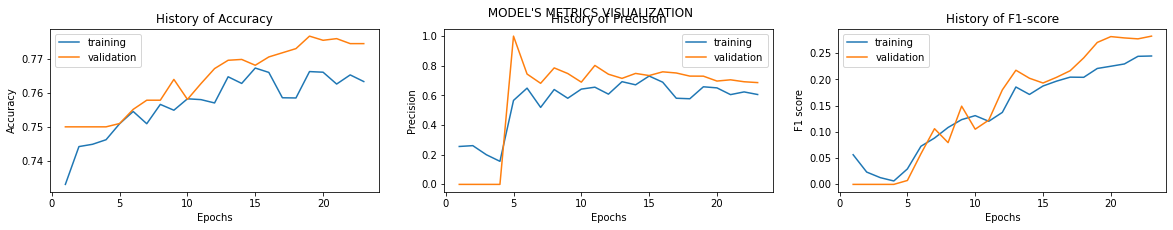

In [54]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,precision,val_precision,f1,val_f1):
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize= (20,3))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    
    ax2.plot(range(1, len(precision) + 1), precision)
    ax2.plot(range(1, len(val_precision) + 1), val_precision)
    ax2.set_title('History of Precision')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Precision')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(f1) + 1), f1)
    ax3.plot(range(1, len(val_f1) + 1), val_f1)
    ax3.set_title('History of F1-score')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('F1 score')
    ax3.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [27]:
model.save('/kaggle/working/zahaimar_v2_1111111111.h5')

In [23]:
scores = model.evaluate(test_dataset)

1279/1279 [==============================] - 15s 12ms/step - loss: 1.1519 - accuracy: 0.7830 - precision: 0.7507 - recall: 0.1978 - auc: 0.7281 - f1_score: 0.1978


In [24]:
print("Accuracy = ", scores[1])
print("Precision = ", scores[2])
print("Recall = ", scores[3])
print("AUC = ", scores[4])
print("F1_score = ", scores[5])

Accuracy =  0.7830336093902588
Precision =  0.7507418394088745
Recall =  0.19781078398227692
AUC =  0.728111982345581
F1_score =  0.19781078398227692


In [25]:
def predict_prob(number):
  return [number[0],1-number[0]]

# Test Data

33.86 % chances are there that the image is [1]


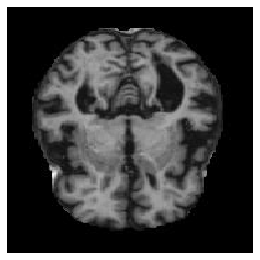

In [43]:
# Test Case 1: 

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented/mildDem0.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

37.13 % chances are there that the image is [2]


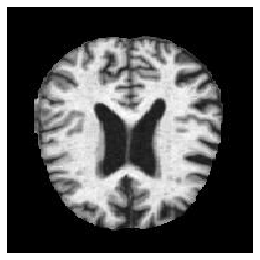

In [26]:
# Test Case 1:  [2]

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented/26 (48).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is', classes)

In [28]:
test_acc = model.evaluate(valid_dataset, verbose = 2)
print("\nTest accuracy: ", test_acc[1])

32/32 - 2s - loss: 1.2374 - accuracy: 0.7696 - precision: 0.7151 - recall: 0.1300 - auc: 0.6603 - f1_score: 0.2153

Test accuracy:  0.7695503234863281


# confusion matrix

In [29]:
import numpy as np
import pandas as pd 
import seaborn as sn 
import tensorflow as tf

In [30]:
print(train_dataset.class_indices.keys())

dict_keys(['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])


In [55]:
from sklearn.metrics import classification_report

Y_pred = model.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(test_dataset.classes, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.08      0.10       179
           1       0.01      0.25      0.02        12
           2       0.51      0.71      0.59       640
           3       0.56      0.01      0.02       448

    accuracy                           0.37      1279
   macro avg       0.30      0.26      0.18      1279
weighted avg       0.47      0.37      0.32      1279



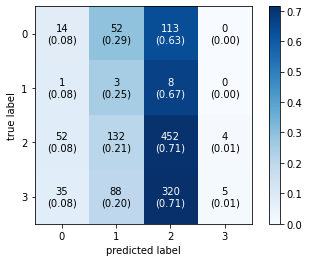

In [56]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(test_dataset.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# Test On new data 

In [44]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [45]:
# Test Data 

test_dataset2  = test_datagen.flow_from_directory(directory = '/kaggle/input/alzheimer-mri-dataset/Dataset',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical')

Found 6400 images belonging to 4 classes.


In [46]:
# Evaluating Loss and AUC

model.evaluate(test_dataset2)

200/200 [==============================] - 34s 168ms/step - loss: 1.1824 - accuracy: 0.7658 - precision: 0.5397 - recall: 0.4302 - auc: 0.7855 - f1_score: 0.4779


[1.1824469566345215,
 0.765820324420929,
 0.5396981239318848,
 0.43015626072883606,
 0.7854720950126648,
 0.4778635799884796]

93.78 % chances are there that the image is class [2]


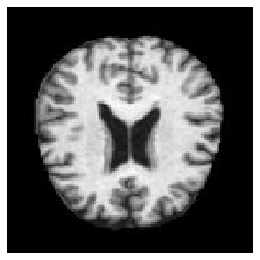

In [47]:
# Test Case : Moderate Demented

dic = test_dataset2.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimer-mri-dataset/Dataset/Non_Demented/non.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
classes = np.argmax(model.predict(img),axis=1)

probability = round(np.max(model.predict(img)*100),2)


print(probability, '% chances are there that the image is class', classes)

# confusion Matrix

In [50]:
true_classes = test_dataset2.classes
class_indices = test_dataset2.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preds = model.predict(test_dataset2)
pred_classes = np.argmax(preds, axis=1)

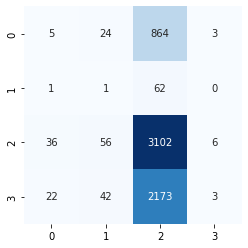

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = test_dataset2.class_indices.keys()

def plot_heatmap(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
    )

plt.figure()
plot_heatmap(true_classes, pred_classes)    

plt.show()